# Closed-Form Solutions to Multiple-View Homography Estimation
This noteboook contains the implementation of the graph synchronization method that can be used to solve the stitching problem in case of multiple images. The implementation resamble the procedure explained in Shroeder et al. 2011.

In [529]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx

In [530]:
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/001/131/original/kon.wav', autoplay=True))

## Variables definition

In [531]:
#Directories
dataset_name = 'mountain_dataset_noise'
dataset_dir = f'datasets/{dataset_name}'
sift_dir = 'sift'
matches_dir = 'matches'
salient_matches_dir ="salient_matches"
output_dir ="output"

In [532]:
#If true store the computed images on disk
save_output = True
M_filename = f"M_{dataset_name}.npy"
C_filename = f"C_{dataset_name}.npy"

## Params definition

In [533]:
matching_threshold = 0.6
number_of_matches = 1
matches_th = 20
RANSACmaxIters = 2000

## Classes and functions definition

In [534]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [535]:
#This class contains the methods and properties related to the features of an image
class ImageFeature:
    def __init__(self, image, index):
        self.image = image
        self.index = index  
        
    #Compute the salient points of the image using SIFT algorithm
    def SIFT(self, save_output = False, output_dir = ""):
        sift = cv.SIFT_create()
        self.kp, self.des = sift.detectAndCompute(self.image,None)
        self.img_with_sift=cv.drawKeypoints(self.image,self.kp,self.image)
        if save_output:
            cv.imwrite(os.path.join(output_dir,f"{self.index+1}.jpg"), self.img_with_sift)

In [536]:
#This class contains the methods and properties related to the problem of feature matching between two images
class Match:
    def __init__(self, image_feature_source, image_feature_destination):
        self.image_feature_source = image_feature_source
        self.image_feature_destination = image_feature_destination
    
    #This function performs feature matching between to images
    def feature_matching(self, threshold, save_output = False, output_dir = ""):
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(self.image_feature_source.des,
                                 self.image_feature_destination.des,
                                 k=2)
        # Need to draw only good matches, so create a mask
        self.good = []
        for m,n in matches:
            if m.distance < threshold*n.distance:
                self.good.append((m,n))
        draw_params = dict(matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           flags = cv.DrawMatchesFlags_DEFAULT)
        self.img_with_match = cv.drawMatchesKnn(self.image_feature_source.image,
                                                self.image_feature_source.kp,
                                                self.image_feature_destination.image,
                                                self.image_feature_destination.kp,
                                                self.good,None,**draw_params)
        if save_output:
            cv.imwrite(os.path.join(output_dir,f"match_{self.image_feature_source.index+1}_{ self.image_feature_destination.index+1}.jpg"),self.img_with_match)
    
    #This function allows to check whether the match between the source and destination images is to be considered a good match
    def check_salient(self, threshold, save_output = False, output_dir = ""):
        #A threshold is used to define the goodness of the  match
        if len(self.good) > threshold:
            if save_output:
                cv.imwrite(os.path.join(output_dir,f"salient_{self.image_feature_source.index+1}_{ self.image_feature_destination.index+1}.jpg"),self.img_with_match)
            return True
        return False
    
    def mult_and_norm(self,H, points):
        proj_p = np.dot(H,points)
        proj_p = proj_p / proj_p[2,:]
        return proj_p[0:2,:]
    
    #This function allows to estimate the homography between the two images
    def fit_homography(self):
        self.src_pts = np.float32([self.image_feature_source.kp[m[0].queryIdx].pt for m in self.good])
        self.dst_pts = np.float32([self.image_feature_destination.kp[m[0].trainIdx].pt for m in self.good])
        
        self.src_pts = np.concatenate((self.src_pts, np.ones([self.src_pts.shape[0],1])), axis=1)
        self.dst_pts = np.concatenate((self.dst_pts, np.ones([self.dst_pts.shape[0],1])), axis=1)
        
        rescale = 1./np.max(self.image_feature_source.image.shape)
        T_norm = np.diag([rescale,rescale,1])
        
        #print(T_norm)
        
        #print(self.src_pts[0,:])
        #print(self.src_pts.shape)
        
        src_pts_proj = self.mult_and_norm(np.eye(3),self.src_pts.transpose()).transpose()
        dst_pts_proj = self.mult_and_norm(np.eye(3),self.dst_pts.transpose()).transpose()
        
        #print(src_pts_proj.shape)
        #print(src_pts_proj[0,:])
        
        self.M, self.mask = cv.findHomography(src_pts_proj, dst_pts_proj, cv.RANSAC, 3.0, maxIters=RANSACmaxIters)
        print(src_pts_proj.shape)
        self.M = T_norm @ self.M @ np.linalg.inv(T_norm)
    
    #This function allows to normalize the homography so that the determinant is unitary
    #This makes homographies part of the SL(3) group
    def normalize_homography(self):
        det = np.linalg.det(self.M)
        self.H = self.M/np.cbrt(det)
        new_det = np.linalg.det(self.H)
        
    #Remember: if src is image I and dest is image J, we are finding H from I to J, this is 
    #Hj,i
    

## Example

In [537]:
#Load the dataset
imgs = load_images_from_folder(dataset_dir)
n = len(imgs) #Number of images

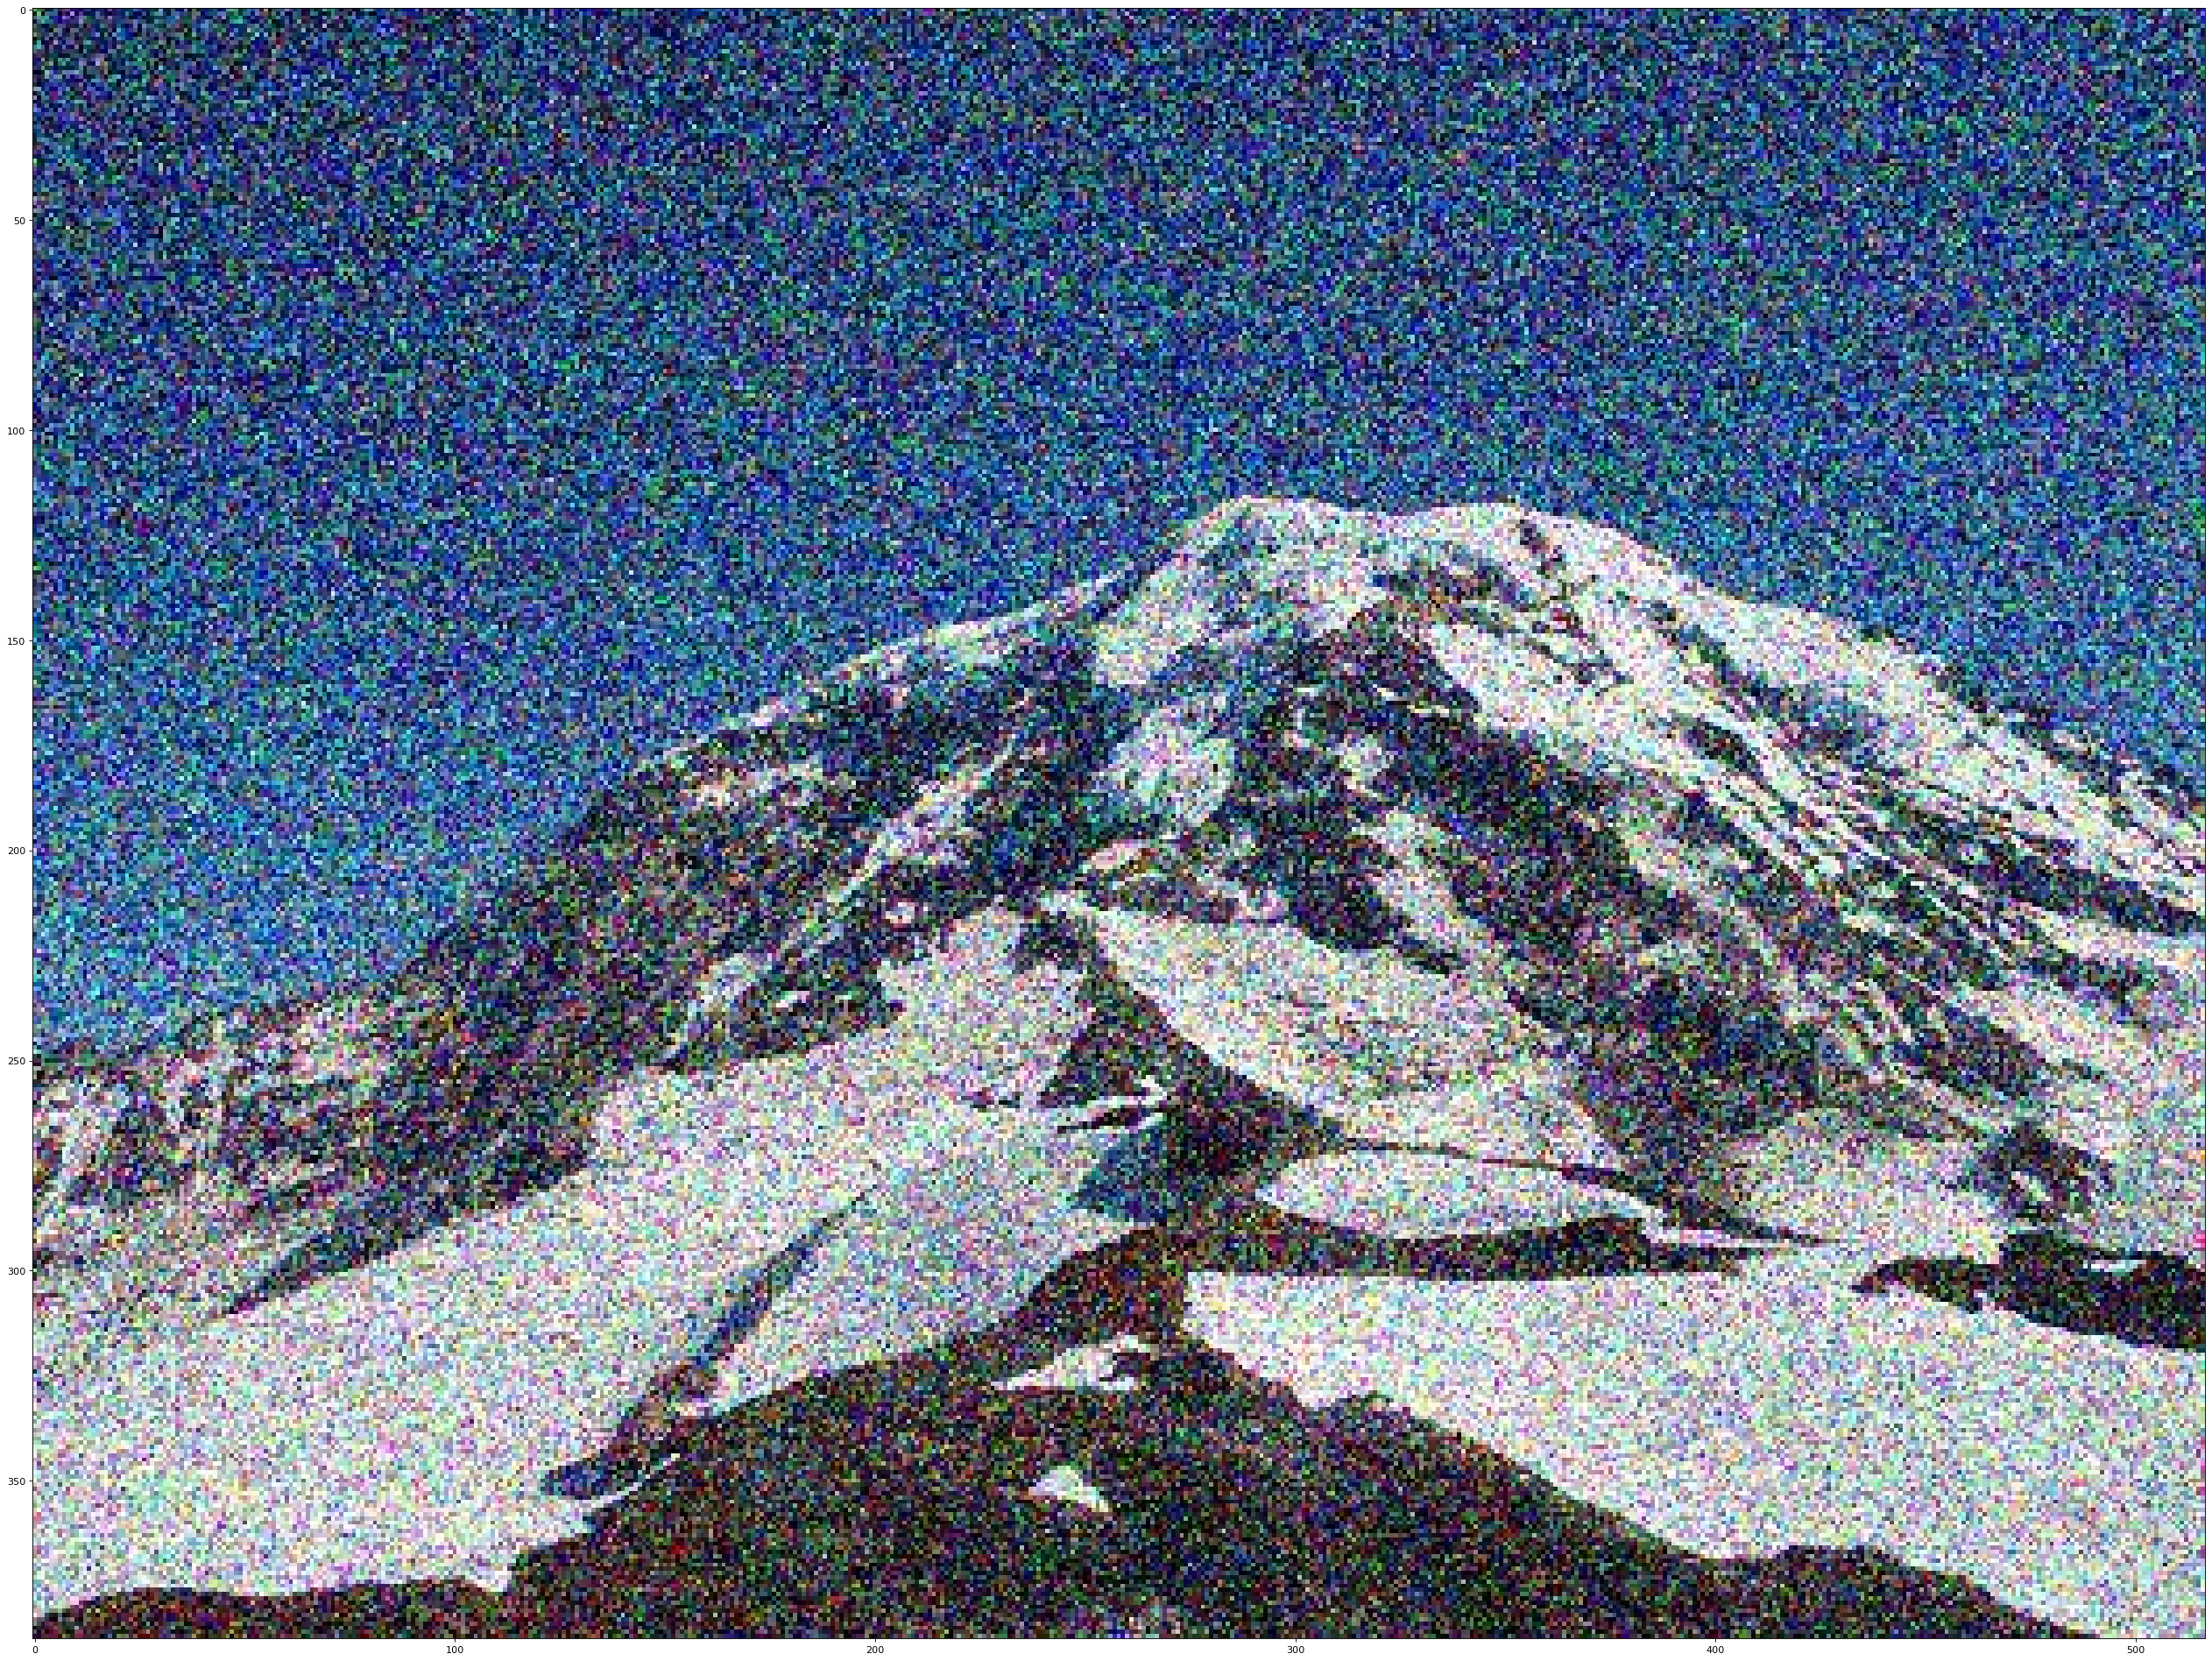

(<matplotlib.image.AxesImage at 0x16196ab7f40>, None)

In [538]:
#Plot an image as example
figure(figsize=(40, 40), dpi=80)
plt.imshow(imgs[0],),plt.show()

In [539]:
#For each image compute the salient points
image_features =[] #Array that will contain the salient features of each image
for i in range(0,n):
    image_feature = ImageFeature(imgs[i], i)
    image_feature.SIFT(save_output, sift_dir)
    image_features.append(image_feature)

In [540]:
#Compute the good matches between each pair of images
matches =[]
for i in range(0, n-1):
    for j in range(i+1, n):
        for k in range(0,number_of_matches):
            match = Match(image_features[i], image_features[j])
            match.feature_matching(matching_threshold, save_output, matches_dir)
            matches.append(match)


salient_matches = list(filter(lambda x: x.check_salient(matches_th, save_output, salient_matches_dir),matches))  


In [541]:
#For every good match, compute also the matches in the reverse order (destination, source)
total_matches = []
for match in salient_matches:
    inv_match = Match(match.image_feature_destination, match.image_feature_source)
    inv_match.feature_matching(matching_threshold, save_output, matches_dir)
    total_matches.append(match)
    total_matches.append(inv_match)

In [542]:
adj_matrix = np.zeros([n,n], dtype=int)
for match in total_matches:
    adj_matrix[match.image_feature_source.index, match.image_feature_destination.index]+=1

## Globally Scaled Homographies (GSH)
Once the good matches have been found, it is possible to used the GSH method in order to get a closed form solution for the problem of aligning all images to a specific coordinate frame.
A homography between two images can easily be estimated from point correspondences using standard procedures. These methods generally ignore the additional information provided by the remaining images in the set and under presence of noise the consistency relationship $H_{i,j} = H_{k,j}*H_{i,k}$ is violated.
This means, that two images may align well to a reference image but may at the same time be badly aligned with each other.In other words, aligning n images to a reference image in order to create a mosaic, requires a set of homographies $U_1,...,U_n$ which by construction
consistently aligns all images to a common reference frame. These global homographies respect the relationship: $H_{i,j} = U_j*U_i^{-1}$.
At this point, the problem is to minimize $C_{GSH}(\hat{U}) = ||G\hat{U}||^2$ under the constraint $\hat{U}^T*\hat{U} = I$. The three right singular vectors associated with the 3 smallest singular values of G provide a solution for the three columns of $\hat{U}$. Thus the problem can be solved using SVD(G). In the previous formulas, $C_{GSH}$ is the cost function to be minimized and G is a matrix computed as follows:
\begin{equation*} G = 
\begin{bmatrix}
    (1-\zeta_1)I & (\gamma H)_{2,1} & \dots  & (\gamma H)_{n,1} \\
    (\gamma H)_{1,2} & (1-\zeta_2)I & \ddots  & \vdots \\
    \vdots & \ddots & \ddots & (\gamma H)_{n,n-1} \\
    (\gamma H)_{1,n} & \dots & (\gamma H)_{n-1,n} & (1-\zeta_n)I
\end{bmatrix}
\end{equation*}
In the matrix, the two terms $\gamma$ and $\zeta$ are defined as follows:
\begin{equation*} \gamma_{i,j} = 
\begin{cases}
1 & \text{if $H_{i,j}$ exists},\\
0 & \text{otherwise}
\end{cases}
\end{equation*}
\begin{equation*} \zeta_{k} = \Sigma_{i = 1}^{n} \gamma_{i,k}
\end{equation*}

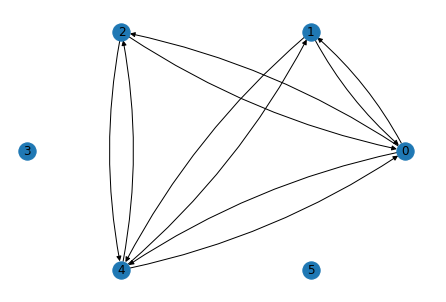

In [543]:
#adj_matrix=np.array([[0, 1, 0, 0],
#                    [0, 0, 3, 2],
#                    [0, 0, 0, 0],
#                    [0, 0, 0, 0]])
graph = nx.from_numpy_matrix(adj_matrix, parallel_edges=True, create_using=nx.MultiDiGraph)
adj_matrix_multi = np.maximum(np.copy(adj_matrix)-1,0)
pos=nx.circular_layout(graph)
nx.draw(graph, pos=pos, with_labels=True, connectionstyle='arc3, rad = 0.1')

In [544]:
def expand_graph(adj_matrix):
    replicas_structure = dict()
    adj_matrix_exp = np.copy(adj_matrix)
    
    #more multiedges, we have to expand
    while np.sum(adj_matrix_exp>1)>0:
        
        adj_matrix_multi = np.maximum(adj_matrix_exp-1,0)
        edges_out = np.sum(adj_matrix_multi, axis=1)
        node_max = np.argmax(edges_out)
        replicas = np.max(adj_matrix_multi[node_max,:])
        appended_column = np.copy(adj_matrix_exp[:,node_max])
        appended_column[node_max]=1
        for i in range(replicas):
            adj_matrix_exp = np.c_[adj_matrix_exp,appended_column]

        row=np.copy(adj_matrix_exp[node_max,:])

        appended_row = np.minimum(1,row)
        adj_matrix_exp[node_max,:] = appended_row
        row = np.maximum(0,row-1)
        for i in range(replicas):
            appended_row = np.minimum(1,row)
            adj_matrix_exp = np.r_[adj_matrix_exp, [appended_row]]
            row = np.maximum(0,row-1)
        
        replicas_structure[node_max] = [node_max] +  list(range(adj_matrix_exp.shape[0]-replicas, adj_matrix_exp.shape[0]))
        
    return adj_matrix_exp, replicas_structure
        

{}


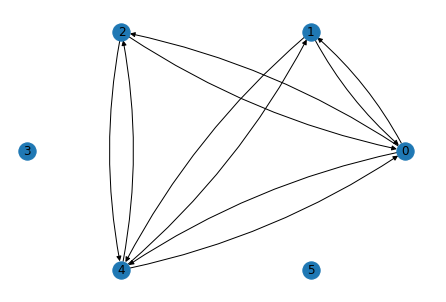

In [545]:
adj_matrix_exp, replicas = expand_graph(adj_matrix)
graph_exp = nx.from_numpy_matrix(adj_matrix_exp, parallel_edges=True, create_using=nx.MultiDiGraph)
pos=nx.circular_layout(graph_exp)
nx.draw(graph_exp, pos=pos, with_labels=True, connectionstyle='arc3, rad = 0.1')
print(replicas)

In [546]:
n_expanded = adj_matrix_exp.shape[0]
matches_handled = np.zeros([n,n], dtype=int)
Z = np.eye(3*n_expanded, 3*n_expanded)
for match in total_matches:
    match.fit_homography()
    match.normalize_homography()
    i_temp=match.image_feature_source.index
    j=match.image_feature_destination.index
    if i_temp in replicas:
        i = replicas[i_temp][(matches_handled[i_temp,j])]
    else:
        i=i_temp    
    if j in replicas:
        for k in replicas[j]:
            Z[3*k:3*(k+1), 3*i:3*(i+1)] = match.H
    else:
        Z[3*j:3*(j+1), 3*i:3*(i+1)] = match.H
    matches_handled[i_temp,j]+=1

for replica in replicas:
    r = replicas[replica]
    for k in r:
        Z[3*k:3*(k+1), 3*r[0]:3*(r[0]+1)] = np.eye(3)

(72, 2)
(76, 2)
(24, 2)
(23, 2)
(46, 2)
(46, 2)
(36, 2)
(34, 2)
(21, 2)
(22, 2)


In [547]:
i1 = 2
i2 = 0

h = Z[(i2)*3:(i2+1)*3,(i1)*3:(i1+1)*3]
print(h)

[[ 1.08905196 -0.02303664 -0.5265503 ]
 [ 0.15177625  0.9479338   0.06409882]
 [ 0.34091382 -0.11220228  0.78538925]]


In [548]:
i1 = 2
i2 = 3

h = Z[(i2)*3:(i2+1)*3,(i1)*3:(i1+1)*3]
print(h)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [549]:
C = np.zeros([3*n_expanded, 3*(n_expanded-n)],dtype=int)
for replica in replicas:
    r = replicas[replica]
    first = r[0]
    for k in r:
        if k != first:
            C[3*first:3*(first+1), 3*(k-n):3*(k-n+1)] = np.eye(3)
            C[3*k:3*(k+1), 3*(k-n):3*(k-n+1)] = -np.eye(3)
print(C)

[]


In [550]:
#Computation of gamma and zeta for each pair of images

D = np.diag(np.sum(adj_matrix_exp + np.eye(n_expanded), axis=1))
D_kron = np.kron(D, np.eye(3))
M = Z - D_kron

In [551]:
np.save(os.path.join(output_dir,M_filename), M)
np.save(os.path.join(output_dir,C_filename), C)

In [552]:
allDone()